# Template Notebook — Seleksi & Ekstraksi Fitur

Tanggal dibuat: **2025-09-15**

Notebook ini disiapkan untuk mengerjakan tugas:

- Seleksi fitur (kategorikal: Chi-Square)
- Seleksi fitur (numerik: t-test/ANOVA)
- Ekstraksi fitur (PCA, n bebas dan n optimal)


## Memanggil Library yang Dibutuhkan

In [ ]:
# Import library yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

# Statistik untuk uji seleksi fitur
from scipy.stats import chi2_contingency, f_oneway, ttest_ind

# PCA dan StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pd.set_option("display.width", 120)



## 1. Memuat Dataset
Ganti path `dataset_path` di bawah dengan dataset yang kamu pilih (bukan *diabetes.csv*).

In [ ]:
# Ganti dengan datasetmu (CSV). Pastikan ada target pada kolom 'target' (ubah sesuai datasetmu).
dataset_path = Path("runners_dataset.csv")   # TODO: ubah ke nama file datasetmu
target_col   = "Level"                   # TODO: ubah ke nama kolom targetmu

use_sklearn_iris = False  # set True untuk contoh cepat dengan iris

if use_sklearn_iris:
    from sklearn.datasets import load_iris
    iris = load_iris(as_frame=True)
    df = iris.frame.rename(columns={"target": "target"})
else:
    if not dataset_path.exists():
        raise FileNotFoundError(f"Tidak menemukan file {dataset_path}. Letakkan dataset di direktori kerja.")
    df = pd.read_csv(dataset_path)

display(df.head())
print("\nTipe data:")
print(df.dtypes)


,Age,WeeklyKM,LongRunKM,AvgPace_min_per_km,RestingHR,Gender,ShoeBrand,TrainingType,Level
0,35,34.8,18.2,6.16,70.9,Female,Asics,Mixed,Intermediate
1,38,21.5,8.8,7.80,75.7,Female,Nike,Interval,Beginner
2,40,20.5,12.9,8.70,73.2,Male,Adidas,Tempo,Beginner
3,32,36.2,10.3,5.78,61.1,Female,Adidas,Interval,Intermediate
4,40,37.5,19.2,6.07,64.9,Male,Nike,Tempo,Intermediate



Tipe data:
Age                     int64
WeeklyKM              float64
LongRunKM             float64
AvgPace_min_per_km    float64
RestingHR             float64
Gender                 object
ShoeBrand              object
TrainingType           object
Level                  object
dtype: object


## 2. Memisahkan Kolom Kategorikal & Numerik
Jika perlu, lakukan casting tipe data (misal `astype('category')`).

In [ ]:
# Deteksi tipe kolom sederhana
categorical_cols = [c for c in df.columns if df[c].dtype == 'object' or str(df[c].dtype).startswith('category')]
numeric_cols     = [c for c in df.columns if c not in categorical_cols and c != target_col]

print("Kolom kategorikal:", categorical_cols)
print("Kolom numerik    :", numeric_cols)

Kolom kategorikal: ['Gender', 'ShoeBrand', 'TrainingType', 'Level']
Kolom numerik    : ['Age', 'WeeklyKM', 'LongRunKM', 'AvgPace_min_per_km', 'RestingHR']


## 3. Seleksi Fitur (Kategorikal) — Chi-Square
Untuk setiap fitur kategorikal, kita uji hubungannya dengan target kategorikal.

In [23]:
# Pastikan target kategorikal
if df[target_col].dtype != 'object' and not str(df[target_col].dtype).startswith('category'):
    # Coba ubah jadi kategori jika masuk akal (misal target kelas 0/1)
    df[target_col] = df[target_col].astype('category')

chi_results = []
for col in categorical_cols:
    if col == target_col:
        continue
    try:
        ct = pd.crosstab(df[col], df[target_col])
        chi2, p, dof, exp = chi2_contingency(ct)
        chi_results.append({"feature": col, "chi2": chi2, "p_value": p, "dof": dof})
    except Exception as e:
        chi_results.append({"feature": col, "error": str(e)})

chi_df = pd.DataFrame(chi_results).sort_values(by=[c for c in ["p_value","chi2"] if c in chi_results[0]], ascending=[True, False] if "p_value" in chi_results[0] else [False])
display(chi_df.head(20))

# Simpan ke CSV
out_chi = Path("hasil_chisquare.csv")
chi_df.to_csv(out_chi, index=False)
print("Disimpan:", out_chi.resolve())


,feature,chi2,p_value,dof
0,Gender,7.114967,0.028510,2
1,ShoeBrand,7.031482,0.317946,6
2,TrainingType,6.135980,0.408131,6


Disimpan: D:\Personal\Kuliah\SEMESTER 5\ML (Prak)\Week5\hasil_chisquare.csv


## 4. Seleksi Fitur (Numerik) — ANOVA / t-test
- Jika target memiliki >2 kelas ⇒ gunakan **ANOVA (f_oneway)**.
- Jika target biner (2 kelas) ⇒ gunakan **t-test (ttest_ind)**.
Pastikan tidak ada NaN dan tipe data sesuai.

In [24]:

# Pastikan target kategori
if df[target_col].dtype != 'object' and not str(df[target_col].dtype).startswith('category'):
    # Jika target biner disimpan sebagai 0/1 numerik, kita buat kategori untuk grouping
    unique_targets = df[target_col].dropna().unique()
    if len(unique_targets) <= 10:
        df[target_col] = df[target_col].astype('category')

anova_results = []
ttest_results = []

classes = list(df[target_col].dropna().unique())
k = len(classes)

if k >= 2:
    # Persiapkan grup per kelas
    groups = {cl: df[df[target_col] == cl] for cl in classes}
    for col in numeric_cols:
        try:
            if k == 2:
                a = groups[classes[0]][col].dropna()
                b = groups[classes[1]][col].dropna()
                # Koindisi var_equal bisa kamu sesuaikan (Levene test), di sini asumsi sederhana
                stat, p = ttest_ind(a, b, equal_var=False)
                ttest_results.append({"feature": col, "t_stat": stat, "p_value": p, "classes": f"{classes[0]} vs {classes[1]}"})
            else:
                arrays = [groups[cl][col].dropna().values for cl in classes]
                stat, p = f_oneway(*arrays)
                anova_results.append({"feature": col, "f_stat": stat, "p_value": p, "classes": str(classes)})
        except Exception as e:
            if k == 2:
                ttest_results.append({"feature": col, "error": str(e)})
            else:
                anova_results.append({"feature": col, "error": str(e)})

anova_df = pd.DataFrame(anova_results)
ttest_df = pd.DataFrame(ttest_results)

# Pilih salah satu yang relevan sesuai jumlah kelas target
if k == 2 and not ttest_df.empty:
    display(ttest_df.sort_values("p_value").head(20))
    out_anova = Path("hasil_ttest.csv")
    ttest_df.to_csv(out_anova, index=False)
    print("Disimpan:", out_anova.resolve())
elif k > 2 and not anova_df.empty:
    display(anova_df.sort_values("p_value").head(20))
    out_anova = Path("hasil_anova.csv")
    anova_df.to_csv(out_anova, index=False)
    print("Disimpan:", out_anova.resolve())
else:
    print("Tidak ada hasil uji numerik yang dapat disimpan. Periksa tipe target atau numeric_cols.")


,feature,f_stat,p_value,classes
1,WeeklyKM,694.254621,6.141842e-90,"['Intermediate', 'Beginner', 'Advanced']"
3,AvgPace_min_per_km,565.323911,2.405797e-82,"['Intermediate', 'Beginner', 'Advanced']"
2,LongRunKM,402.720999,2.515283e-70,"['Intermediate', 'Beginner', 'Advanced']"
4,RestingHR,304.657272,5.178819e-61,"['Intermediate', 'Beginner', 'Advanced']"
0,Age,1.544522,2.159868e-01,"['Intermediate', 'Beginner', 'Advanced']"


Disimpan: D:\Personal\Kuliah\SEMESTER 5\ML (Prak)\Week5\hasil_anova.csv


## 5. Ekstraksi Fitur — PCA (n_components bebas)
Gunakan `StandardScaler` sebelum PCA. Pilih `n_components` sesuai kebutuhan (misal 2 untuk visualisasi).

Explained variance ratio: [0.68079351 0.20137923]
Total explained variance: 0.8821727385814951
Disimpan: D:\Personal\Kuliah\SEMESTER 5\ML (Prak)\Week5\hasil_pca_nbebas.csv


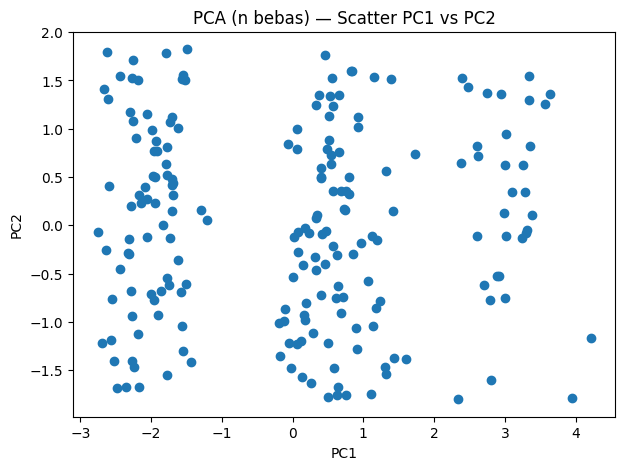

In [25]:

# Pilih fitur numerik untuk PCA
X = df[numeric_cols].select_dtypes(include=[np.number]).dropna()

# Standardisasi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Tentukan jumlah komponen bebas (misal 2)
n_components_free = 2  # TODO: ubah sesuai kebutuhan
pca_free = PCA(n_components=n_components_free)
X_pca_free = pca_free.fit_transform(X_scaled)

# Simpan hasil ke CSV
pca_free_df = pd.DataFrame(X_pca_free, columns=[f"PC{i+1}" for i in range(n_components_free)])
# Jika ingin menambahkan target kembali (jika panjang sama dan baris tanpa NaN)
if len(pca_free_df) == len(df):
    pca_free_df[target_col] = df[target_col].values

out_pca_free = Path("hasil_pca_nbebas.csv")
pca_free_df.to_csv(out_pca_free, index=False)
print("Explained variance ratio:", pca_free.explained_variance_ratio_)
print("Total explained variance:", pca_free.explained_variance_ratio_.sum())
print("Disimpan:", out_pca_free.resolve())

# Plot (1 plot saja, tanpa seaborn, tanpa set warna khusus)
plt.figure(figsize=(7,5))
if n_components_free >= 2:
    plt.scatter(pca_free_df["PC1"], pca_free_df["PC2"])
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA (n bebas) — Scatter PC1 vs PC2")
else:
    plt.plot(pca_free_df["PC1"])
    plt.xlabel("Index")
    plt.ylabel("PC1")
    plt.title("PCA (n bebas) — PC1")
plt.show()


## 6. Ekstraksi Fitur — PCA (n_components optimal)
Menentukan jumlah komponen optimal berdasarkan varians kumulatif (misal ≥ 90%).

Explained variance ratio: [0.68079351 0.20137923 0.04499111 0.03773361 0.03510254]
Cumulative sum: [0.68079351 0.88217274 0.92716385 0.96489746 1.        ]
Komponen optimal (≈>=90%): 3
Total explained variance (optimal): 0.9271638475264677
Disimpan: D:\Personal\Kuliah\SEMESTER 5\ML (Prak)\Week5\hasil_pca_optimal.csv


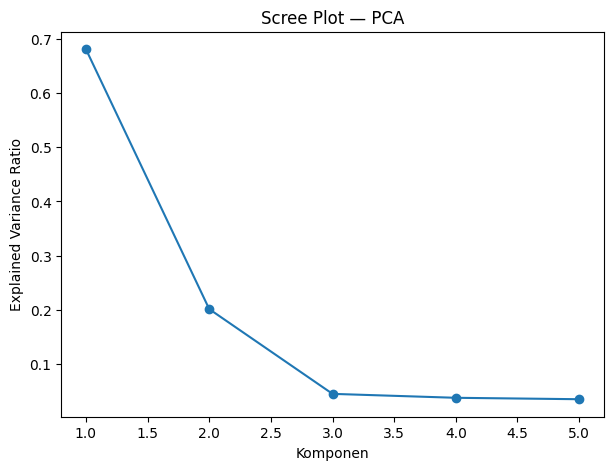

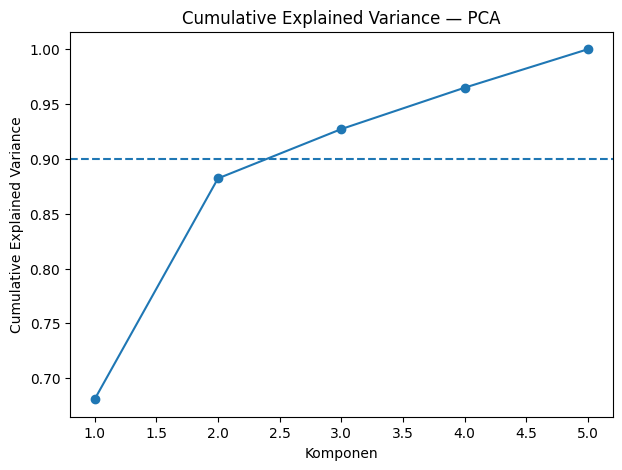

In [11]:

# Cari jumlah komponen dengan ambang varians kumulatif
threshold = 0.90  # 90%
pca_full = PCA()
pca_full.fit(X_scaled)
cumsum = np.cumsum(pca_full.explained_variance_ratio_)
n_opt = int(np.searchsorted(cumsum, threshold) + 1)

print("Explained variance ratio:", pca_full.explained_variance_ratio_)
print("Cumulative sum:", cumsum)
print("Komponen optimal (≈>=90%):", n_opt)

# Fit ulang dengan n_opt
pca_opt = PCA(n_components=n_opt)
X_pca_opt = pca_opt.fit_transform(X_scaled)

pca_opt_df = pd.DataFrame(X_pca_opt, columns=[f"PC{i+1}" for i in range(n_opt)])
if len(pca_opt_df) == len(df):
    pca_opt_df[target_col] = df[target_col].values

out_pca_opt = Path("hasil_pca_optimal.csv")
pca_opt_df.to_csv(out_pca_opt, index=False)
print("Total explained variance (optimal):", pca_opt.explained_variance_ratio_.sum())
print("Disimpan:", out_pca_opt.resolve())

# Plot scree (tanpa set warna khusus)
plt.figure(figsize=(7,5))
plt.plot(range(1, len(pca_full.explained_variance_ratio_)+1), pca_full.explained_variance_ratio_, marker='o')
plt.xlabel("Komponen")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot — PCA")
plt.show()

# Plot cumulative
plt.figure(figsize=(7,5))
plt.plot(range(1, len(cumsum)+1), cumsum, marker='o')
plt.axhline(y=threshold, linestyle='--')
plt.xlabel("Komponen")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance — PCA")
plt.show()
